# Deep Dive into Molecular Search Engine with Towhee

In the [previous tutorial](1_build_molecular_search_engine.ipynb), we built and prototyped a proof-of-concept molecular search engine. Now, let's feed it with large-scale image datasets, and deploy it as a micro-service.

## Preparation
If you haven't done so already, please go through our previous tutorial: "[Build a Molecular Search Engine in Minutes](./1_build_molecular_search_engine.ipynb)". To make things easy, we'll repeat the important code blocks below; if you have already executed these blocks, please move on to next section.

### Install Dependencies
First we need to install dependencies such as milvus, towhee, rdkit and gradio.

> There are several ways to install Milvus. You can [install Milvus Standalone](https://milvus.io/docs/v2.0.x/install_standalone-docker.md) or [install Milvus Cluster](https://milvus.io/docs/v2.0.x/install_cluster-docker.md). The `pip install milvus` in this notebook is still in internal testing, if you plan to put it into production please use another method.

In [1]:
! python -m pip install -q milvus towhee rdkit-pypi fastapi

### Prepare the Data
There is a subset of the [Pubchem dataset](https://ftp.ncbi.nlm.nih.gov/pubchem/Compound/CURRENT-Full/SDF/) (10000 SMILES) used in this demo, everyone can download on [Github](https://github.com/towhee-io/examples/releases/download/data/pubchem_10000.smi).

In [2]:
! curl -L https://github.com/towhee-io/examples/releases/download/data/pubchem_10000.smi -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  561k  100  561k    0     0   221k      0  0:00:02  0:00:02 --:--:-- 1109k


To use the dataset for molecular search, let's first define the dictionary and helper function:
- `id_smiles`: a dictionary of id and corresponding smiles;
- `to_images(input)`: convert the input smiles or results to towhee.Image for display.

In [3]:
import pandas as pd
from rdkit.Chem import Draw
from rdkit import Chem
from towhee.types.image_utils import from_pil

df = pd.read_csv('pubchem_10000.smi')
id_smiles = df.set_index('id')['smiles'].to_dict()

def to_images(inputs):
    if isinstance(inputs, str):
        smiles = inputs
        mol = Chem.MolFromSmiles(smiles)
        return from_pil(Draw.MolToImage(mol))
    imgs = []
    results = inputs
    for re in results:
        smiles = id_smiles[re.id]
        mol = Chem.MolFromSmiles(smiles)
        imgs.append(from_pil(Draw.MolToImage(mol)))
    return imgs

### Start Milvus and Create Collection

Next we need to start Milvus and create a Milvus Collection, first run `milvus.before()` and make sure that the current environment has completed for first Milvus environment configuration.

In [4]:
import milvus
milvus.before()

---(For linux users) if you are running Milvus for the first time, run milvus.before() for env variables setting instructions---
---otherwise, run milvus.start()---
please set the following env variables in bash:
export LD_PRELOAD=/Users/chenshiyu/.virtualenvs/shiyu/lib/python3.8/site-packages/milvus/bin/embd-milvus.so
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/lib:/usr/local/lib:/tmp/milvus/lib


Then we need to set environment variables, and please change the "LD_PRELOAD" variable to the above output.

If `milvus.before()` also shows that dependencies need to be installed, please run `sh install_deps.sh` on your machine.

In [5]:
import os
os.environ["LD_PRELOAD"] = "/Users/chenshiyu/.virtualenvs/shiyu/lib/python3.8/site-packages/milvus/bin/embd-milvus.so"
os.environ["LD_LIBRARY_PATH"] = "$LD_LIBRARY_PATH:/usr/lib:/usr/local/lib:/tmp/milvus/lib"

Once Milvus is ready, you can run `milvus.start()`, which may take a few minutes until printing "---Milvus agent successfully initialized and ready to serve!--". Without `time.sleep()` the result of this line may be printed to the notebook's command line after a few minutes, you can check jupyter's output. So please make sure milvus has started with printing that line.

In [6]:
import time
milvus.start()
time.sleep(30)

---Milvus Proxy successfully initialized and ready to serve!---


Next to create the "molsearch" collection in Milvus. It's worth to note that the vector field of this collection is the type of "BINARY_VECTOR".

In [7]:
from pymilvus import connections, FieldSchema, CollectionSchema, DataType, Collection, utility

def create_milvus_collection(collection_name, dim):
    connections.connect(host='127.0.0.1', port='19530')
    
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
    
    fields = [
    FieldSchema(name='id', dtype=DataType.INT64, descrition='ids', is_primary=True, auto_id=False),
    FieldSchema(name='embedding', dtype=DataType.BINARY_VECTOR, descrition='embedding vectors', dim=dim)
    ]
    schema = CollectionSchema(fields=fields, description='molecular similarity search')
    collection = Collection(name=collection_name, schema=schema)
    
    return collection

collection = create_milvus_collection('molsearch', 2048)

Then load smiles data to Milvus with Towhee, more details in ["Build a Molecular Search Engine in Minutes"](./1_build_molecular_search_engine.ipynb)

In [8]:
import towhee

dc = (
    towhee.read_csv('pubchem_10000.smi')
      .runas_op['id', 'id'](func=lambda x: int(x))
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
      .to_milvus['id', 'fp'](collection=collection, batch=100)
)

## Making the Molecular Search Engine Production Ready

To put the molecular search engine into production, we need to feed it with a large-scale dataset and deploy a microservice to accept incoming queries. Towhee has exception_safe execution mode to ensure system stability.

### Exception Safe Execution

When we have large-scale data, there may be bad data that will cause errors. Typically, we don't want such errors to break the production system. Therefore, the data pipeline should continue to process the rest of the data and report the errors.

Towhee supports an exception-safe execution mode that allows the pipeline to continue on exceptions and represent the exceptions with `Empty` values. The user can choose how to deal with the Empty values at the end of the pipeline. 

During the query below, there are four SMILES in total, one of them is an error formula, it just prints an error message instead of terminating because it has `exception_safe` and `drop_empty`, as you can see, `drop_empty` deletes empty data.

[17:45:24] SMILES Parse Error: syntax error while parsing: CCFGS
[17:45:24] SMILES Parse Error: Failed parsing SMILES 'CCFGS' for input: 'CCFGS'
2022-05-18 17:45:24,028 - 139658782036544 - rdkit.py-rdkit:55 - ERROR: Python argument types in
    rdkit.Chem.rdmolops.RDKFingerprint(NoneType)
did not match C++ signature:
    RDKFingerprint(RDKit::ROMol mol, unsigned int minPath=1, unsigned int maxPath=7, unsigned int fpSize=2048, unsigned int nBitsPerHash=2, bool useHs=True, double tgtDensity=0.0, unsigned int minSize=128, bool branchedPaths=True, bool useBondOrder=True, boost::python::api::object atomInvariants=0, boost::python::api::object fromAtoms=0, boost::python::api::object atomBits=None, boost::python::api::object bitInfo=None), cannot generate fingerprint of CCFGS.


smiles,similar_smile
,
,
,

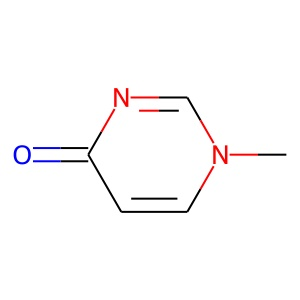
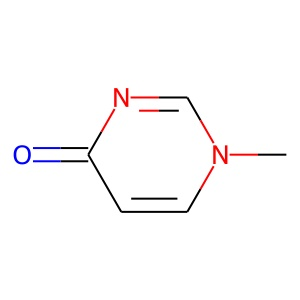
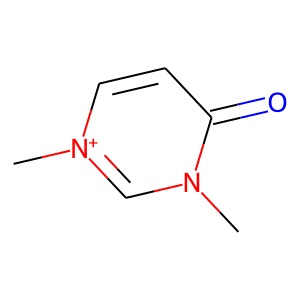
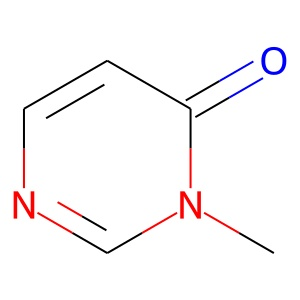
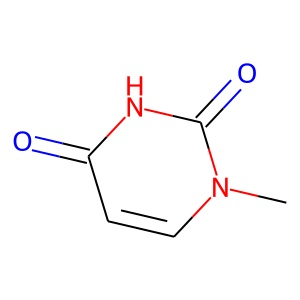
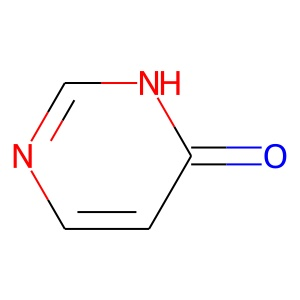
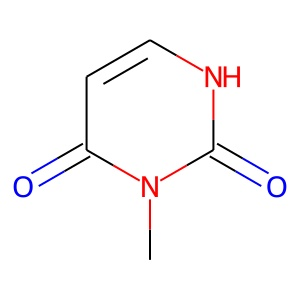
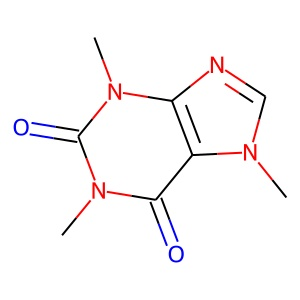
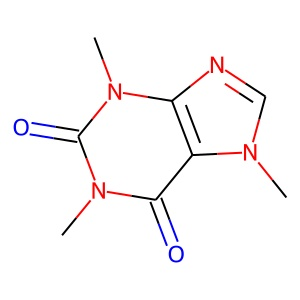
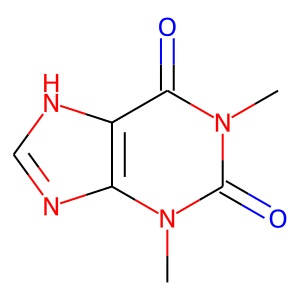
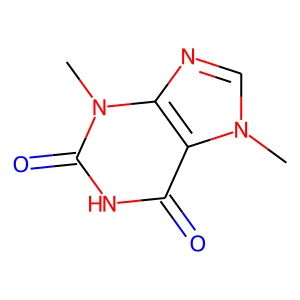
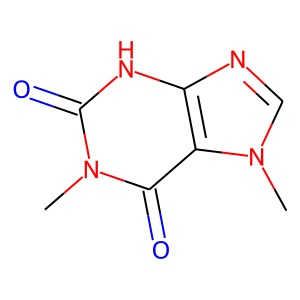
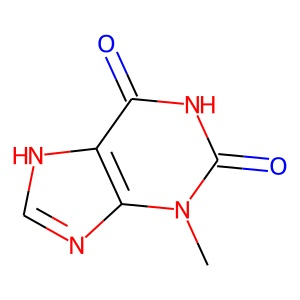
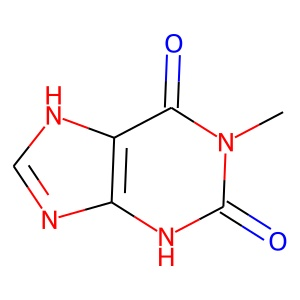
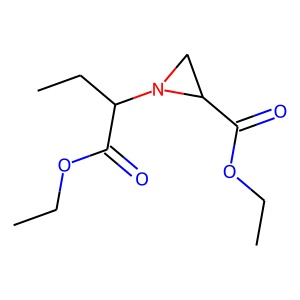
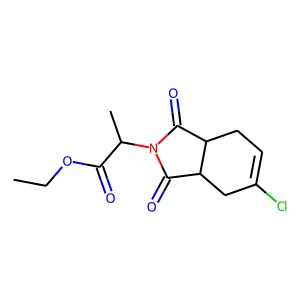
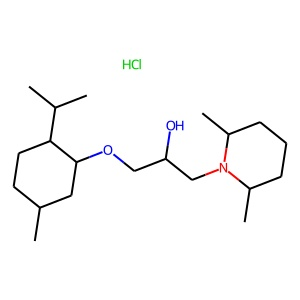
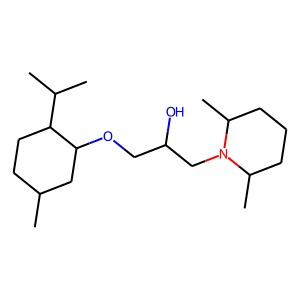
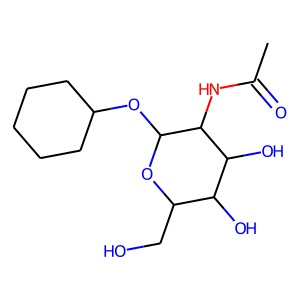
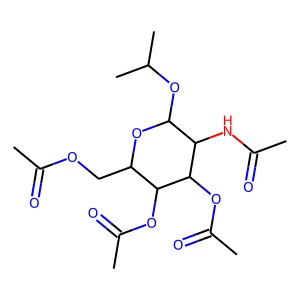
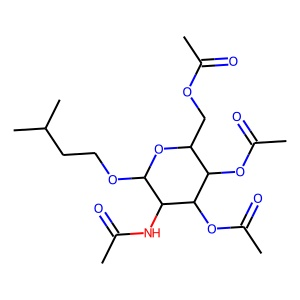

In [9]:
( towhee.dc['smiles'](['Cn1ccc(=O)nc1', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C', 'CCOC(=O)C1CN1C(C(=O)OCC)CC', 'CCFGS'])
      .exception_safe()
      .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
      .milvus_search['fp', 'result'](collection=collection, metric_type='JACCARD', limit=6)
      .runas_op['result', 'similar_smile'](func=to_images)
      .runas_op['smiles', 'smiles'](func=to_images)
      .drop_empty()
      .select['smiles', 'similar_smile']()
      .show()
)

### Deploy as a Microservice

The data pipeline used in our experiments can be converted to a function with `towhee.api` and `as_function()`, as it is presented in [previous tutorial](1_build_molecular_search_engine.ipynb). We can also convert the data pipeline into a RESTful API with `serve()`, it generates FastAPI services from towhee pipelines.

#### Insert SMILES Data

In [10]:
import time
import towhee
from fastapi import FastAPI
from pymilvus import connections, Collection

app = FastAPI()
connections.connect(host='127.0.0.1', port='19530')
milvus_collection = Collection('molsearch')


@towhee.register(name='get_smiles_id')
def get_smiles_id(smiles):
    timestamp = int(time.time()*10000)
    id_smiles[timestamp] = smiles
    return timestamp

@towhee.register(name='milvus_insert')
class MilvusInsert:
    def __init__(self, collection):
        self.collection = collection

    def __call__(self, *args, **kwargs):
        data = []
        for iterable in args:
            data.append([iterable])
        mr = self.collection.insert(data)
        self.collection.load()
        return str(mr)


with towhee.api['smiles']() as api:
    app_insert = (
        api.get_smiles_id['smiles', 'id']()
        .molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
        .milvus_insert[('id', 'fp'), 'res'](collection=milvus_collection)
        .select['id', 'res']()
        .serve('/insert', app)
    )

#### Similarity Search

In [11]:
with towhee.api['smiles']() as api:
    app_search = (
        api.molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
        .milvus_search['fp', 'result'](collection=milvus_collection, metric_type='JACCARD')
        .runas_op['result', 'similar_smile'](func=lambda res: [id_smiles[x.id] for x in res])
        .select['smiles', 'similar_smile']()
        .serve('/similarity', app)
    )

#### Superstructure Search

In [12]:
with towhee.api['smiles']() as api:
    app_search = (
        api.molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
        .milvus_search['fp', 'result'](collection=milvus_collection, metric_type='SUPERSTRUCTURE')
        .runas_op['result', 'superstructure'](func=lambda res: [id_smiles[x.id] for x in res])
        .select['smiles', 'superstructure']()
        .serve('/superstructure', app)
    )

#### Substructure Search

In [13]:
with towhee.api['smiles']() as api:
    app_search = (
        api.molecular_fingerprinting['smiles', 'fp'](algorithm='daylight')
        .milvus_search['fp', 'result'](collection=milvus_collection, metric_type='SUBSTRUCTURE')
        .runas_op['result', 'substructure'](func=lambda res: [id_smiles[x.id] for x in res])
        .select['smiles', 'substructure']()
        .serve('/substructure', app)
    )

#### Count Numbers

In [14]:
with towhee.api() as api:
    app_count = (
        api.map(lambda _: milvus_collection.num_entities)
        .serve('/count', app)
        )

#### Start Server

Start Server
Finally to start FastAPI, there are five services /insert, /similarity, /superstructure, /substructure and /count, you can run the following commands to test:

```bash
# search the similar molecular
$ curl -X POST "http://0.0.0.0:8000/similarity"  --data "Cn1ccc(=O)nc1"

# search the superstructure molecular
$ curl -X POST "http://0.0.0.0:8000/superstructure"  --data "Cn1ccc(=O)nc1"

# search the substructure molecular
$ curl -X POST "http://0.0.0.0:8000/substructure"  --data "Cn1ccc(=O)nc1"

# insert a molecular
$ curl -X POST "http://0.0.0.0:8000/insert"  --data "Cn1ccc(=O)nc1"

# count the collection
$ curl -X POST "http://0.0.0.0:8000/count"
```

In [15]:
import uvicorn
import nest_asyncio

nest_asyncio.apply()
uvicorn.run(app=app, host='0.0.0.0', port=8000)

INFO:     Started server process [18346]
2022-05-18 17:48:09,109 - 139977945969216 - server.py-server:64 - INFO: Started server process [18346]
INFO:     Waiting for application startup.
2022-05-18 17:48:09,110 - 139977945969216 - on.py-on:26 - INFO: Waiting for application startup.
INFO:     Application startup complete.
2022-05-18 17:48:09,111 - 139977945969216 - on.py-on:38 - INFO: Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
2022-05-18 17:48:09,113 - 139977945969216 - server.py-server:199 - INFO: Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
2022-05-18 17:48:10,520 - 139977945969216 - server.py-server:239 - INFO: Shutting down
INFO:     Waiting for application shutdown.
2022-05-18 17:48:10,624 - 139977945969216 - on.py-on:43 - INFO: Waiting for application shutdown.
INFO:     Application shutdown complete.
2022-05-18 17:48:10,627 - 139977945969216 - on.py-on:46 - INFO: Application shutd